# Pipeline Analysis for CSM Model

- Plot Heatmaps of the model results using Z-normalization
- CEZ/OEZ Pooled Patient Analysis
- CEZ/OEZ IRR Metric

In [3]:
import os
import sys
import collections
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import scipy.stats
from sklearn.metrics import roc_curve, auc, precision_recall_curve, \
    average_precision_score, confusion_matrix, accuracy_score
from pprint import pprint
import copy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

sys.path.append("../../")

%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import dabest

from eztrack.edm.classifiers.evaluate.dataset import Dataset, Patient
from eztrack.edm.classifiers.evaluate.pipeline import EvaluationFramework
from eztrack.edm.classifiers.evaluate.model_selection import get_clinical_split, compute_category_regression, \
            compute_splits_train, large_scale_train

from eztrack.edv.results.plot_distributions import PlotDistributions
from eztrack.edv.base.utils import plot_baseline, plot_boxplot, plot_pr, \
    plot_roc, plot_confusion_matrix, plot_boxplot_withdf
from eztrack.base.utils.data_science_utils import cutoff_youdens, split_inds_engel, \
    split_inds_clindiff, split_inds_outcome, get_numerical_outcome, compute_minmaxfragilitymetric, compute_fragilitymetric,\
    compute_znormalized_fragilitymetric, split_inds_modality
from eztrack.edm.classifiers.model.cez_oez_analyzer import FragilitySplitAnalyzer
from eztrack.pipeline.experiments.cez_vs_oez.center_cezvsoez import plot_results
from eztrack.edp.objects.clinical.master_clinical import MasterClinicalSheet
from eztrack.edp.loaders.dataset.clinical.excel_meta import ExcelReader

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_per_patient_results(timewarpdict_dataset):
    # reorder them into patients
    timewarp_patient = collections.defaultdict(list)
    datasetids = []
    for datasetid in sorted(timewarpdict_dataset.keys()):
        # extract the patient id
        patid = datasetid.split("_")[0]
        _datasetid = datasetid.split("_")[0]
        datasetids.append(_datasetid)

        # extract the data from each dataset and the corresponding cez/oez matrix
        data = timewarpdict_dataset[datasetid]
        cezmat = data['cezmat']
        oezmat = data['oezmat']
        if oezmat.shape[0] == 0 or cezmat.shape[0] == 0:
            print(cezmat.shape, oezmat.shape)
            print(patid, datasetid)
            continue

        # add to patient's list of datasets
        timewarp_patient[patid].append((cezmat, oezmat))

    totaldatasets = 0
    for pat in timewarp_patient.keys():
        totaldatasets += len(timewarp_patient[pat])

    return timewarp_patient, datasetids, totaldatasets

In [5]:
datadir = "/Users/adam2392/Dropbox/phd_research/Fragility_Analysis_Project/"
# datadir = "/home/adam2392/Documents/Dropbox/phd_research/Fragility_Analysis_Project/"

excelfilename = "organized_clinical_datasheet_raw.xlsx"
excelfilepath = os.path.join(datadir, excelfilename)

outputexcelfilename = "organized_clinical_datasheet_formatted.xlsx"
outputexcelfilepath = os.path.join(datadir, outputexcelfilename)
print(os.path.exists(excelfilepath))
print(excelfilepath)

True
/Users/adam2392/Dropbox/phd_research/Fragility_Analysis_Project/organized_clinical_datasheet_raw.xlsx


In [6]:
clinreader = ExcelReader(excelfilepath)

In [7]:
ieegdf, datasetdf, scalpdf = clinreader.read_formatted_df()

In [8]:
mastersheet = MasterClinicalSheet(ieegdf, datasetdf, scalpdf)

In [9]:
figdir = "/Users/adam2392/Downloads/journalfigs/"

# Load In Data

In [10]:
modality = 'ieeg'
# modality = 'scalp'
reference = "common_avg"
reference = "monopolar"

modelname = "impulse"
networkmodelname = ""
freqband = ""
expname = "trimmed"

datadir = f"/Users/adam2392/Downloads/output_new/{expname}/{modelname}{networkmodelname}/{reference}/{modality}/"

resultfilepath = os.path.join(datadir, f"{modelname}_responses.npz")
if not os.path.exists(resultfilepath):
    resultfilepath = os.path.join(datadir, f"networkstatic_responses.npz")
allfiles = os.listdir(datadir)
print(allfiles)
    
# data that is only timewarped, but without threshold applied yet
# datadir = "/Users/adam2392/Downloads/output_new/joined_results/timewarp_nothreshold/"
# datadir = "/Users/adam2392/Downloads/output_new/common_avg_timewarp_nothresh/"

['jhu', 'nih', 'ummc', 'cleveland']


# Create Plots of Data

First create for successful patients, then for failure patients.

In [11]:
COMBINE_SEPARATE_PATS = [
    'pt11',
    'nl22',
    'ummc007',
    'tvb7',
    'nl02', 'nl06', 'nl11', # no resection
]

ignore_pats = [
#     'pt11',
#     'jh107'
    'la01-2','la01',
    'la03', 'la05', 
#     'la09', 
    'la23',
    'nl22',
]

center = 'nih'

dict_dataset = dict()
centerdir = os.path.join(datadir, center)
if freqband != "":
    centerdir = os.path.join(centerdir, freqband)
resultfilepath = os.path.join(centerdir, f"{modelname}_responses.npz")
if not os.path.exists(resultfilepath):
    resultfilepath = os.path.join(centerdir, f"networkstatic_responses.npz")
if not os.path.exists(resultfilepath):
    resultfilepath = os.path.join(centerdir, f"impulsemodel_magnitude1_responses.npz")
allfiles = os.listdir(os.path.join(centerdir))

# load in the dataset
trainresult = np.load(resultfilepath, allow_pickle=True)
dict_dataset.update(**trainresult['timewarpdict'].item())

dataset_patient, datasetids, numdatasets = get_per_patient_results(dict_dataset)
print(dataset_patient.keys())
print(numdatasets)

dict_keys(['pt10', 'pt11', 'pt12', 'pt13', 'pt14', 'pt15', 'pt16', 'pt1', 'pt2', 'pt3', 'pt6', 'pt7', 'pt8'])
41


In [12]:
dict_dataset = dict()
centers = [
#     'clevelandnl', 
    'cleveland',
    'nih',
    'jhu',
    'ummc'
]

for center in centers:
    centerdir = os.path.join(datadir, center)
    if freqband != "":
        centerdir = os.path.join(centerdir, freqband)
    resultfilepath = os.path.join(centerdir, f"{modelname}_responses.npz")
#     print(resultfilepath)
    if not os.path.exists(resultfilepath):
        resultfilepath = os.path.join(centerdir, f"networkstatic_responses.npz")
    if not os.path.exists(resultfilepath):
        resultfilepath = os.path.join(centerdir, f"impulsemodel_magnitude1_responses.npz")
    allfiles = os.listdir(os.path.join(centerdir))
    # load in the datasete
    result = np.load(resultfilepath, allow_pickle=True)
    dict_dataset.update(**result['timewarpdict'].item())

print(dict_dataset.keys())
dataset_patient, datasetids, totaldatasets = get_per_patient_results(dict_dataset)
print(totaldatasets)


dict_keys(['la22_sz_5p', 'la11_sz', 'la01_sz', 'la13_sz_1', 'la08_sz', 'la02_sz', 'la06_sz', 'la04_sz', 'la07_sz_1', 'la17_sz', 'la22_sz_6p', 'la08_sz_1pg', 'la22_sz_7p', 'la06_sz_1p', 'pt1_sz_2', 'pt1_sz_6', 'pt1_sz_4', 'pt1_sz_3', 'pt12_sz_2', 'pt15_sz_1', 'pt10_sz_2', 'pt15_sz_2', 'pt16_sz_1', 'pt16_sz_3', 'pt10_sz_1', 'pt15_sz_3', 'pt2_sz_4', 'pt6_sz_5', 'pt6_sz_4', 'pt10_sz_3', 'pt12_sz_1', 'pt6_sz_3', 'pt7_sz_22', 'pt2_sz_3', 'pt15_sz_4', 'pt16_sz_2', 'pt3_sz_2', 'pt2_sz_1', 'pt14_sz_1', 'pt3_sz_4', 'pt14_sz_2', 'pt7_sz_21', 'pt14_sz_3', 'pt11_sz_2', 'pt11_sz_4', 'pt11_sz_3', 'pt7_sz_19', 'pt8_sz_1', 'pt8_sz_2', 'pt11_sz_1', 'pt8_sz_3', 'pt13_sz_3', 'pt13_sz_5', 'pt13_sz_2', 'pt13_sz_1', 'jh107_sz_8', 'jh107_sz_7', 'jh107_sz_9', 'jh107_sz_1', 'jh107_sz_2', 'jh107_sz_4', 'jh102_sz_3', 'jh102_sz_6', 'jh104_sz_1', 'jh103_sz_3', 'jh103_sz_1', 'jh108_sz_3', 'jh105_sz_5', 'jh105_sz_1', 'jh108_sz_4', 'jh108_sz_6', 'jh105_sz_2', 'jh105_sz_3', 'jh105_sz_4', 'jh108_sz_5', 'jh108_sz_7', 'jh

In [22]:
plotter = PlotDistributions(figdir)

print(dataset_patient.keys())

jhcount = 0
umcount = 0
nihcount = 0
cccount = 0

for key in dataset_patient.keys():
    if 'jh' in key:
        jhcount += 1
    elif 'ummc' in key:
        umcount += 1
    elif 'pt' in key:
        nihcount += 1
    elif 'la' in key:
        cccount += 1
print(jhcount)
print(umcount, nihcount, cccount)
print(6+9+13+10)

dict_keys(['jh102', 'jh103', 'jh104', 'jh105', 'jh107', 'jh108', 'la01', 'la02', 'la04', 'la06', 'la07', 'la08', 'la11', 'la13', 'la17', 'la22', 'pt10', 'pt11', 'pt12', 'pt13', 'pt14', 'pt15', 'pt16', 'pt1', 'pt2', 'pt3', 'pt6', 'pt7', 'pt8', 'ummc001', 'ummc002', 'ummc003', 'ummc004', 'ummc005', 'ummc006', 'ummc007', 'ummc008', 'ummc009'])
6
9 13 10
38


# Dataset Summary

In [32]:
failcount = 0
successcount = 0

engel_count_dict = dict()
for patient in patientlist:
    if patient.outcome == 'nr':
        continue
    elif patient.outcome == 'f':
        failcount += 1
    else:
        successcount += 1
    
    if str(patient.engelscore) not in engel_count_dict.keys():
        engel_count_dict[str(patient.engelscore)] = 0
    engel_count_dict[str(patient.engelscore)] += 1
    
print(failcount, successcount)
print(engel_count_dict)

14 19
{'4.0': 4, '1.0': 19, '2.0': 8, '3.0': 2}


In [33]:
print(4+19+8+2)

33


In [14]:
cez_chs = []
other_chs = []
allpats = []

for pat in dataset_patient.keys():
    datasets = dataset_patient[pat]
    
    if pat in ignore_pats:
        continue
    
    cezs = []
    oezs = []
    print(pat)
    
    # normalize
    print(len(datasets))
#     for i in range(len(datasets)):
#         cezmat, oezmat = datasets[i]
# #         print(cezmat.shape, oezmat.shape)
#         mat = np.concatenate((cezmat, oezmat), axis=0)
#         mat = compute_minmaxfragilitymetric(mat)
#         cezmat = mat[:cezmat.shape[0], :]
#         oezmat = mat[cezmat.shape[0]:, :]
#         print(cezmat.shape, oezmat.shape)
    
    for i in range(len(datasets)):
        cezmat, oezmat = datasets[i]
        
        mat = np.concatenate((cezmat, oezmat), axis=0)
#         mat = compute_fragilitymetric(mat)
        cezmat = mat[:cezmat.shape[0], :]
        oezmat = mat[cezmat.shape[0]:, :]
        
        if pat in joinseppats:
            cezs.append(np.mean(cezmat, axis=0))
            oezs.append(np.mean(oezmat, axis=0))
        else:
            cezs.append(cezmat)
            oezs.append(oezmat)
    
    if pat not in joinseppats:
        cezs = np.nanmedian(np.array(cezs), axis=0)
        oezs = np.nanmedian(np.array(oezs), axis=0)
        
#     print(np.array(cezs).shape)
    
    # store the entire patient concatenated vector
    cez_chs.append(np.mean(cezs, axis=0))
    other_chs.append(np.mean(oezs, axis=0))
    allpats.append(pat)
    
cez_chs = np.array(cez_chs)
other_chs = np.array(other_chs)

jh102
2


NameError: name 'joinseppats' is not defined

In [ ]:
print(cez_chs.shape, other_chs.shape)

In [157]:
# split by outcome
succ_inds, fail_inds = split_inds_outcome(allpats, mastersheet)

print(len(succ_inds), len(fail_inds))
print(totaldatasets)
center = ", ".join(centers)
print(center)

19 14
101
cleveland, nih, jhu, ummc


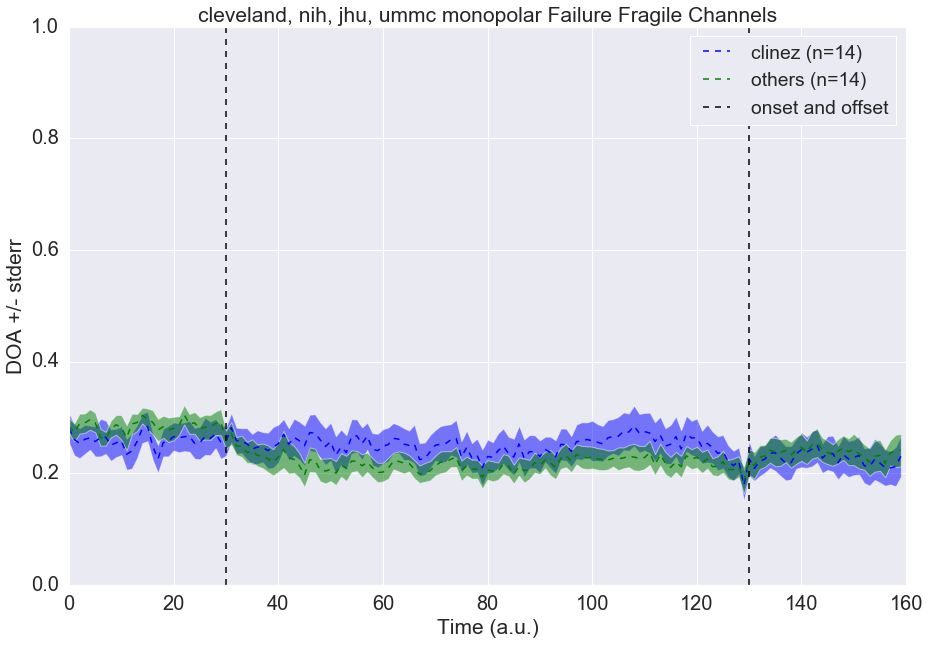

In [174]:
sns.set(font_scale=1.75)

cez_mat_fail = cez_chs[fail_inds,...]
oez_mat_fail = other_chs[fail_inds,...]

# take the average across all patients
mean_onset = np.nanmean(cez_mat_fail, axis=0)
mean_other = np.nanmean(oez_mat_fail, axis=0)
stderr_onset = scipy.stats.sem(cez_mat_fail, nan_policy='omit', axis=0)
stderr_other = scipy.stats.sem(oez_mat_fail, nan_policy='omit', axis=0)

# mean_onset[mean_onset > 3] = 5
# mean_other[mean_other > 3] = 5
# stderr_onset[np.abs(stderr_onset) > 3] = 3
# stderr_other[np.abs(stderr_other) > 3] = 3

xs = [np.arange(len(mean_onset)), np.arange(len(mean_other))]
ys = [mean_onset, mean_other]
errors = [stderr_onset, stderr_other]
labels = ['clinez (n={})'.format(len(cez_mat_fail)), 
          'others (n={})'.format(len(oez_mat_fail))]
threshstr = "\n Thresh=0.7"
# threshstr = ""
titlestr="{center} {reference} Failure Fragile Channels".format(center=center, 
                                                                         reference=reference)
xlabel = "Normalized Window Around Seizure Onset (+/- 10 secs)"
vertline = [30,130]
# vertline = [offsetwin]
fig, ax = plotter.plot_comparison_distribution(xs, ys, labels=labels, alpha=0.5,
                                               save=True, 
#                                                ylim=[0,7.5],
                                               figure_name=titlestr,
                                           errors=errors, 
                                            titlestr=titlestr, 
                                               ylabel="DOA +/- stderr",
                                               xlabel="Time (a.u.)",
                                           vertlines=vertline)

(37, 160) (37, 160)


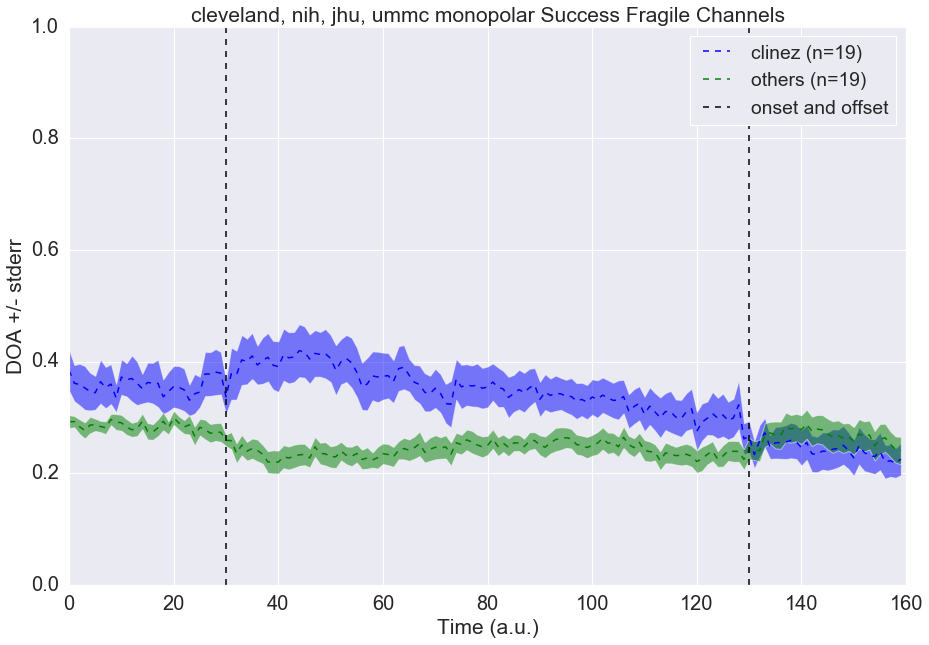

In [175]:
print(cez_chs.shape, other_chs.shape)
cez_mat = cez_chs[succ_inds,...]
oez_mat = other_chs[succ_inds,...]

# take the average across all patients
mean_onset = np.mean(cez_mat, axis=0)
mean_other = np.mean(oez_mat, axis=0)
stderr_onset = scipy.stats.sem(cez_mat, axis=0)
stderr_other = scipy.stats.sem(oez_mat, axis=0)

# mean_onset[mean_onset>5] = 5
# mean_other[mean_other>5] = 5
# stderr_onset[stderr_onset > 5] = 5
# stderr_other[stderr_other > 5] = 5

xs = [np.arange(len(mean_onset)), np.arange(len(mean_other))]
ys = [mean_onset, mean_other]
errors = [stderr_onset, stderr_other]
labels = ['clinez (n={})'.format(len(cez_mat)), 
          'others (n={})'.format(len(oez_mat))]
threshstr = "\n Thresh=0.7"
# threshstr = ""
titlestr="{center} {reference} Success Fragile Channels".format(center=center, 
                                                                         reference=reference)
xlabel = "Normalized Window Around Seizure Onset (+/- 10 secs)"
vertline = [30,130]
# vertline = [offsetwin]
fig, ax = plotter.plot_comparison_distribution(xs, ys, labels=labels, 
                                               save=True,
#                                                 ylim=[0, 7],
                                               figure_name=titlestr,
                                           errors=errors, 
                                            titlestr=titlestr, 
                                               ylabel="DOA +/- stderr",
                                               xlabel="Time (a.u.)",
                                           vertlines=vertline)

# Create Pipeline Object

In [15]:
def plot_summary(succ_ezratios, fail_ezratios, clinical_baseline,
                engelscore_box, clindiff_box,
                fpr, tpr, precision, recall, average_precision,
                youdenind, youdenpred, titlestr, clf_auc,
                Y_pred_engel, Y_pred_clindiff):
    ylabel = "DOA Metric"

    # plotting for baselines
    baselinex_roc = [0, 1-(clinical_baseline-0.5)]
    baseliney_roc = [0+(clinical_baseline-0.5), 1]
    baselinex_pr = [0, 1]
    baseliney_pr = [clinical_baseline, clinical_baseline]

    # make box plot
    plt.style.use("classic")
    sns.set_style("white")
    fix, axs = plt.subplots(2,3, figsize=(25,15))
    axs = axs.flatten()
    ax = axs[0]
    titlestr = f"Outcome Split N={numdatasets} P={numpats}"
    boxdict = [
        [fail_ezratios, succ_ezratios],
        [ 'Fail', 'Success']
    ]
    plot_boxplot(ax, boxdict, titlestr, ylabel)

    outcome_df = create_df_from_outcome(succ_ezratios, fail_ezratios)
    outcome_dabest = dabest.load(data=outcome_df, 
                                 x='outcome', y="ezr",
                              idx=('failure','success')
                                )
    # Produce a Cumming estimation plot.
    outcome_dabest.mean_diff.plot();
    
    ax = axs[1]
    titlestr = f"Engel Score Split N={numdatasets} P={numpats}"
    plot_boxplot(ax, engelscore_box, 
                 titlestr, ylabel="")
    xticks = ax.get_xticks()
    ax.plot(xticks, Y_pred_engel, 
            color='red',
            label=f"y={engel_intercept:.2f} + {engel_slope:.2f}x"
           )
    ax.legend()

    ax = axs[2]
    titlestr = f"Clin Difficulty Split N={numdatasets} P={numpats}"
    plot_boxplot(ax, clindiff_box, titlestr, 
                 ylabel="")
    ax.plot(xticks, Y_pred_clindiff, color='red', 
            label=f"y={clindiff_intercept:.2f} + {clindiff_slope:.2f}x")
    ax.legend()

    # make ROC Curve plot
    ax = axs[3]
    titlestr = f"ROC Curve N={numdatasets} P={numpats}"
    label = "ROC Curve (AUC = %0.2f)" % (clf_auc)
    plot_roc(ax, fpr, tpr, label, titlestr)
    plot_baseline(ax, baselinex_roc, baseliney_roc)
    ax.legend(loc='lower right')
    ax.plot(np.mean(baselinex_roc).squeeze(), np.mean(baseliney_roc).squeeze(), 
            'k*', linewidth=4, markersize=12, 
            label=f"Clinical-Baseline {np.round(clinical_baseline, 2)}"
           )
    ax.plot(fpr[youdenind], tpr[youdenind], 
            'r*', linewidth=4, markersize=12, 
            label=f"Youden-Index {np.round(youdenacc, 2)}")
    ax.legend(loc='lower right')

    # make PR Curve
    ax = axs[4]
    label = 'PR Curve (AP = %0.2f)' % (average_precision)
    titlestr = f"PR-Curve N={numdatasets} P={numpats}"
    plot_pr(ax, recall, precision, label, titlestr)
    plot_baseline(ax, baselinex_pr, baseliney_pr)
    ax.legend(loc='lower right')

    # Confusion Matrix
    ax = axs[5]
    titlestr = f"Confusion matrix Youdens-cutoff"
    plot_confusion_matrix(ax, ytrue, youdenpred, classes=[0.,1.],
                          title=titlestr, normalize=True)

#     titlestr = f"{modelname}{networkmodelname}-{freqband} {center} N={numdatasets} P={numpats}"
    # plt.savefig(os.path.join(figdir, normname, titlestr+".png"), 
    #             box_inches='tight')

(64, 160)
CPU times: user 413 ms, sys: 71.8 ms, total: 485 ms
Wall time: 362 ms


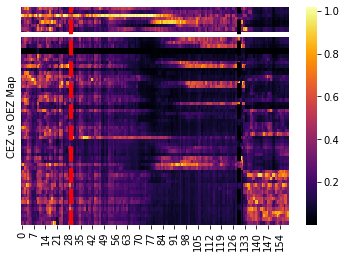

In [16]:
%%time

# create patient list for all datasets
patientlist = []

for patientid in dataset_patient.keys():
    # initialize empty list to store datasets per patient
    datasetlist = []
    
    if patientid in ignore_pats:
        continue
        
    # get metadata for patient
    center = mastersheet.get_patient_center(patientid)
    outcome = mastersheet.get_patient_outcome(patientid)
    engelscore = mastersheet.get_patient_engelscore(patientid)
    clindiff = mastersheet.get_patient_clinicaldiff(patientid)
    modality = mastersheet.get_patient_modality(patientid)
    
    for datasetname, result in dict_dataset.items():
        # get the patient/dataset id
        patid = datasetname.split("_")[0]
        datasetid = datasetname.split(patid + "_")[1]
        
#         print(patid, datasetid)
        if patid != patientid:
            continue
        # format the matrix and the indices
        mat = np.concatenate((result['cezmat'], result['oezmat']), axis=0)
        cezinds = np.arange(0, result['cezmat'].shape[0])

        # create dataset object
        dataset_obj = Dataset(mat=mat, 
                              patientid=patid,
                              name=datasetid,
                              datatype='ieeg', 
                              cezinds=cezinds, 
                              markeron=30, 
                              markeroff=130)
        datasetlist.append(dataset_obj)

    if patientid == 'pt2':
        print(mat.shape)
        ax = sns.heatmap(mat,cmap='inferno',
                         yticklabels=[],
#                          vmax=3, 
#                          vmin=-3
                        )
        ax.axhline(len(cezinds), linewidth=5, color='white')
        ax.set_ylabel("CEZ vs OEZ Map")
        ax.axvline(30, linewidth=4, linestyle='--', color='red')
        ax.axvline(130, linewidth=4, linestyle='--', color='black')
        
    # create patient object
    patient_obj = Patient(datasetlist, 
                         name=patientid,
                         center=center,
                         outcome=outcome,
                         engelscore=engelscore,
                         clindiff=clindiff,
                         modality=modality)
    patientlist.append(patient_obj)
#     print(patient_obj, len(datasetlist))
evalpipe = EvaluationFramework(patientlist)

In [17]:
print(patient_obj)
print(evalpipe.centers, evalpipe.modalities)
print(evalpipe)

COMBINE_SEPARATE_PATS = [
    'pt11',
#     'nl22',
    'ummc007',
#     'tvb7',
#     'nl02', 'nl06', 'nl11', # no resection
]

ignore_pats = [
#     'pt11',
#     'jh107'
#     'jh102', 'jh104',
    'la01-2','la01',
    'la03', 'la05', 
#     'la09', 
    'la23',
    'nl22',
]

ummc009 (ecog, s, 1.0, 1.0) - ummc w/ 3 datasets
['cc' 'jhh' 'nih' 'ummc'] ['ecog' 'seeg']
37 Patients - 100 Data Snapshots


In [41]:
# evalpipe.apply_normalization(normalizemethod=None)
ezr_list = evalpipe.compute_ezratios(
#                                     threshold=0.5,
                    ignore_pats=ignore_pats, 
                     combine_sep_pats=COMBINE_SEPARATE_PATS
                    )
nr_inds = evalpipe.remove_nr_inds()
surgery_inds = evalpipe.get_surgery_inds()

jh102
jh103
jh104
jh105
jh107
jh108
la02
la04
la06
la07
la08
la11
la13
la17
la22
pt10
pt11
pt12
pt13
pt14
pt15
pt16
pt1
pt2
pt3
pt6
pt7
pt8
ummc001
ummc002
ummc003
ummc004
ummc005
ummc006
ummc007
ummc008
ummc009


In [42]:
ezratios = ezr_list[surgery_inds]
patlist = evalpipe.patientlist[surgery_inds]

# split by outcome
succ_inds, fail_inds = split_inds_outcome(patlist, mastersheet)
ytrue = get_numerical_outcome(patlist, mastersheet)
engel_inds_dict = split_inds_engel(patlist, mastersheet)
clindiff_inds_dict = split_inds_clindiff(patlist, mastersheet)

roc_dict, cm = evalpipe.evaluate_roc_performance(ezratios, ytrue, 
                                                 normalize=True)

pr_dict = evalpipe.evaluate_pr_performance(ezratios, ytrue, pos_label=1)

# extract data from dictionaries
fpr = roc_dict['fpr']
tpr = roc_dict['tpr']
clf_auc = roc_dict['auc']
youdenthreshold = roc_dict['youdenthresh']
youdenacc = roc_dict['youdenacc']
youdenind = roc_dict['youdenind']
precision = pr_dict['prec']
recall = pr_dict['recall']
average_precision = pr_dict['avgprec']
clinical_baseline = pr_dict['baseline']

# youden prediction
youdenpred = ezratios >= youdenthreshold
youdenpred = [int(y == True) for y in youdenpred]
# evaluate box plot separation using wilcoxon rank-sum
succ_ezratios, fail_ezratios, \
    stat, pval = evalpipe.evaluate_metric_separation(ytrue, ezratios, pos_label=1, neg_label=0)

print("Wilcoxon Rank-sum: ", stat, pval)
print("Clinical baseline: ", clinical_baseline)
print(sum(ytrue))
# pprint(pr_dict)

Normalized confusion matrix
Wilcoxon Rank-sum:  2.0398506592577563 0.04136520236222277
Clinical baseline:  0.5757575757575758
19


In [43]:
engelscore_box = {}
for i in sorted(engel_inds_dict.keys()):
    if i == -1:
        continue
    if np.isnan(i):
        continue
    this_fratio = ezratios[engel_inds_dict[i]]
    engelscore_box[f"ENG{int(i)}"] = this_fratio
    
clindiff_box = {}
for i in sorted(clindiff_inds_dict.keys()):
    this_fratio = ezratios[clindiff_inds_dict[i]]
    clindiff_box[f"CD{int(i)}"] = this_fratio
print("Total amount of data: ", len(ezratios), len(patlist))

Total amount of data:  33 33


In [254]:

linear_regressor = LinearRegression()  # create object for the class

X = []
y = []
for idx, engelscore in enumerate(engelscore_box.keys()):
    print(engelscore)
    y.append(np.mean(engelscore_box[engelscore]))
    X.append(idx+1)
X = np.array(X)[:, np.newaxis]
linear_regressor.fit(X, y)  # perform linear regression
engel_intercept = linear_regressor.intercept_
engel_slope = linear_regressor.coef_[0]
Y_pred_engel = linear_regressor.predict(X)  # make predictions

X = []
y = []
for idx, clindiff in enumerate(clindiff_box.keys()):
    print(clindiff)
    y.append(np.mean(clindiff_box[clindiff]))
    X.append(idx+1)
X = np.array(X)[:, np.newaxis]
linear_regressor.fit(X, y)  # perform linear regression
clindiff_intercept = linear_regressor.intercept_
clindiff_slope = linear_regressor.coef_[0]
Y_pred_clindiff = linear_regressor.predict(X)  # make predictions

print(X, y)
print("Slope and intercept: ", clindiff_slope, clindiff_intercept)

ENG1
ENG2
ENG3
ENG4
CD1
CD2
CD3
CD4
[[1]
 [2]
 [3]
 [4]] [0.5392008014783284, 0.5469054273374603, 0.5455448985873456, 0.4966586046210598]
Slope and intercept:  -0.012898711932192044 0.5643242128365286


Normalized confusion matrix


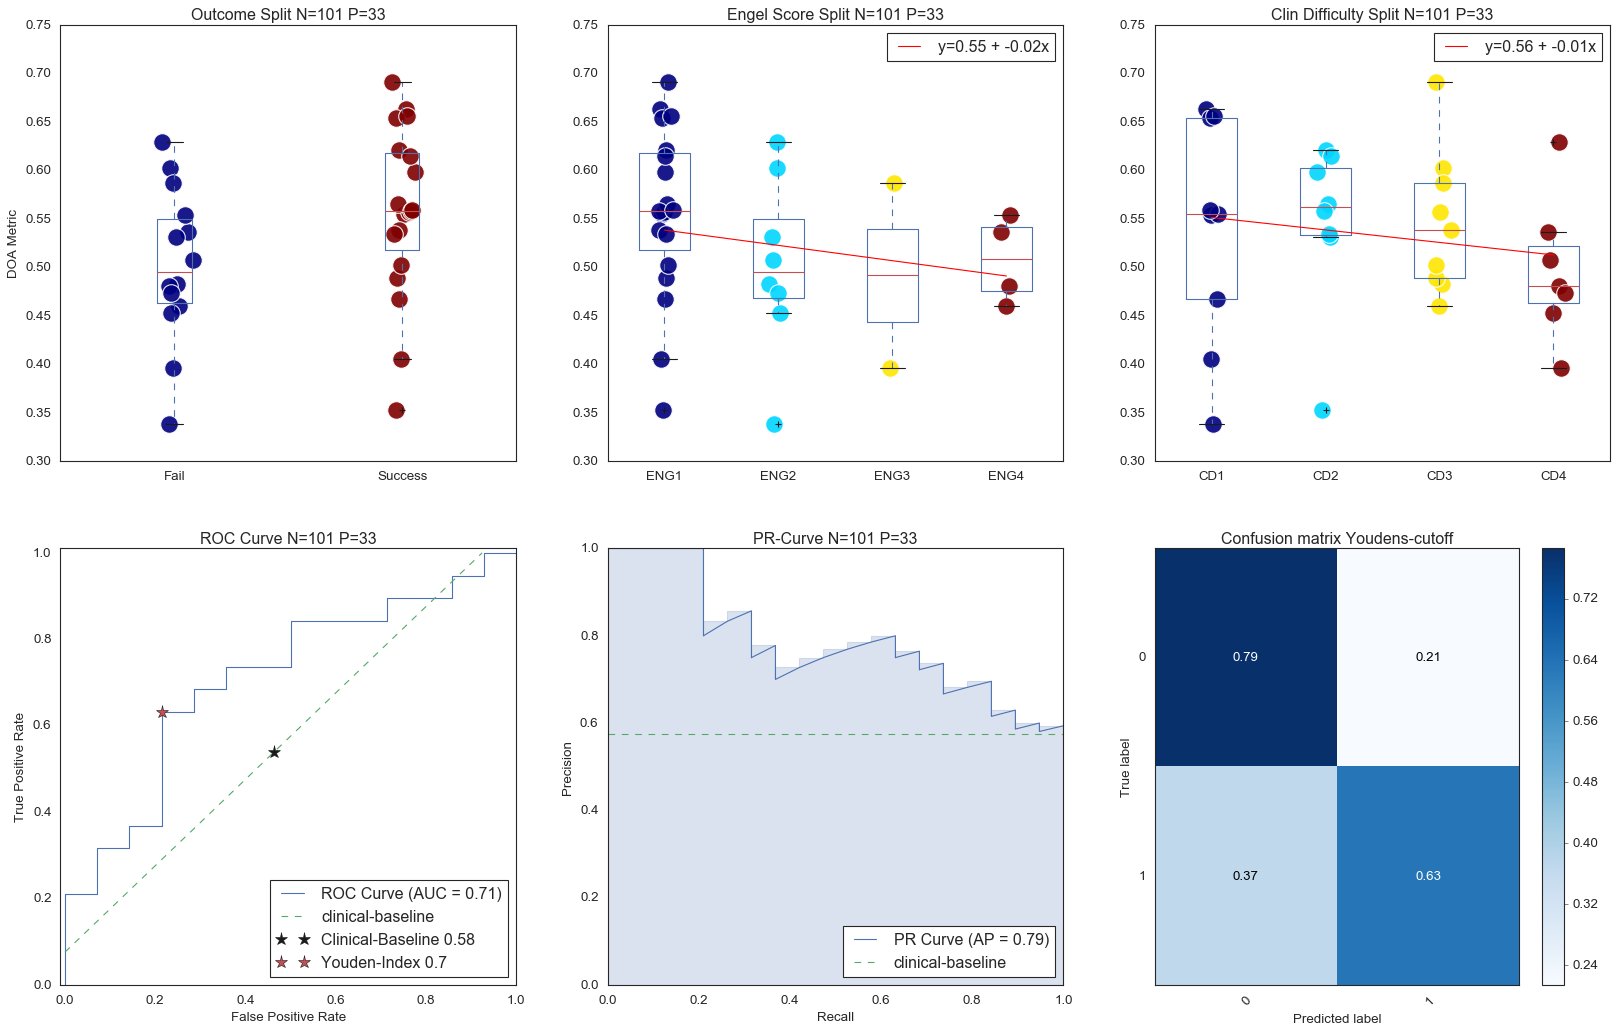

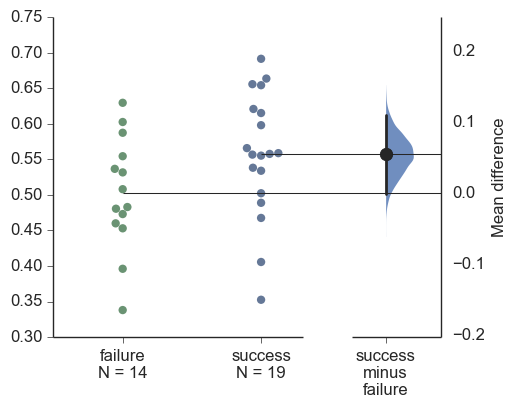

In [261]:
sns.set(font_scale=2.5)
centernames = "UMMC, JHH, CC"
numpats = len(patlist)
numdatasets = totaldatasets
# titlestr = f"{modelname}{networkmodelname}-{freqband} {center} N={numdatasets} P={numpats}"
titlestr= f"{modelname}{networkmodelname}-{freqband} {centernames} N={numdatasets} P={numpats}"
titlestr = ""
plot_summary(succ_ezratios, fail_ezratios, clinical_baseline,
            engelscore_box, clindiff_box,
            fpr, tpr, precision, recall, average_precision,
            youdenind, youdenpred, titlestr, clf_auc,
            Y_pred_engel, Y_pred_clindiff)

In [227]:
print("Outlier min on fratio_succ: ", 
      patlist[ezratios==min(succ_ezratios)])
print("Outlier max oon fratio_fail: ", 
      patlist[ezratios==max(fail_ezratios)])

argsort_succ = np.sort(succ_ezratios)
topinds = [ezratios.tolist().index(argsort_succ[i]) for i in range(10)]
succ_bad_pats = patlist[topinds]

print("\n\n Outlier of success patients:")
print(succ_bad_pats)

argsort_fail = np.sort(fail_ezratios)[::-1]
topinds = [ezratios.tolist().index(argsort_fail[i]) for i in range(10)]
fail_bad_pats = patlist[topinds]

print("\n\n Outlier of failed patients:")
print(fail_bad_pats)

Outlier min on fratio_succ:  ['jh107']
Outlier max oon fratio_fail:  ['pt6']


 Outlier of success patients:
['jh107' 'pt16' 'pt15' 'la07' 'pt11' 'ummc005' 'pt8' 'pt2' 'pt3' 'ummc008']


 Outlier of failed patients:
['pt6' 'la13' 'pt7' 'pt14' 'jh108' 'la22' 'la04' 'la06' 'la17' 'pt12']


# Train/Test Split

In [55]:
# traininds, testinds = train_test_split(np.arange(len(y)), test_size=0.6, random_state=98765)
traininds, testinds = evalpipe.train_test_split(method='engel', 
                                                trainsize=0.50)

print(len(traininds), len(testinds))

''' RUN TRAINING '''
ezratios = ezr_list[surgery_inds]
# ezratios = ezratios[traininds]
patlist = evalpipe.patientlist[surgery_inds]
# patlist = patlist[traininds]

numpats = len(patlist)
print(len(patlist), len(ezratios))
# split by outcome
succ_inds, fail_inds = split_inds_outcome(patlist, mastersheet)
ytrue = get_numerical_outcome(patlist, mastersheet)
engel_inds_dict = split_inds_engel(patlist, mastersheet)
clindiff_inds_dict = split_inds_clindiff(patlist, mastersheet)

succ_ezratios = ezratios[succ_inds]
fail_ezratios = ezratios[fail_inds]

# engel / clindiff metric split into dictionary
engel_metric_dict = get_clinical_split(ezratios, 'engel', engel_inds_dict)
clindiff_metric_dict = get_clinical_split(ezratios, 'clindiff', clindiff_inds_dict)

# create dictionary split engel and clindiff classes
engel_metric_dict = get_clinical_split(ezratios, 'engel', engel_inds_dict)
clindiff_metric_dict = get_clinical_split(ezratios, 'clindiff', clindiff_inds_dict)

Y_pred_engel, engel_intercept, engel_slope = compute_category_regression(engel_metric_dict)
Y_pred_clindiff, clindiff_intercept, clindiff_slope = compute_category_regression(clindiff_metric_dict)


18 22
33 33
ENG_1
ENG_2
ENG_3
ENG_4
CD_1
CD_2
CD_3
CD_4


In [56]:
ezrcolvals = np.concatenate((succ_ezratios, fail_ezratios), axis=-1)[:, np.newaxis]
scorevals = np.array(['Success']*len(succ_ezratios) + ['Failure']*len(fail_ezratios))[:, np.newaxis]
outcome_df = pd.DataFrame(data=ezrcolvals, columns=['ezr'])
outcome_df['Outcome'] = scorevals

ezrcolvals = []
scorevals = []
for key, vals in engel_metric_dict.items():
    scorevals.extend([key] * len(vals))
    ezrcolvals.extend(vals)
engel_df = pd.DataFrame(data=ezrcolvals, columns=['ezr'])
engel_df['Engel Score'] = scorevals

ezrcolvals = []
scorevals = []
for key, vals in clindiff_metric_dict.items():
    scorevals.extend([key] * len(vals))
    ezrcolvals.extend(vals)
clindiff_df = pd.DataFrame(data=ezrcolvals, columns=['ezr'])
clindiff_df['Epilepsy Category'] = scorevals

print("converted clinical categorizations into dataframes!")
display(outcome_df.head())
display(engel_df.head())
display(clindiff_df.head())

converted clinical categorizations into dataframes!


,ezr,Outcome
0,0.620805,Success
1,0.352487,Success
2,0.663559,Success
3,0.488834,Success
4,0.502304,Success


,ezr,Engel Score
0,0.620805,ENG_1
1,0.352487,ENG_1
2,0.663559,ENG_1
3,0.488834,ENG_1
4,0.502304,ENG_1


,ezr,Epilepsy Category
0,0.663559,CD_1
1,0.338000,CD_1
2,0.554355,CD_1
3,0.467555,CD_1
4,0.405611,CD_1


In [65]:
outcome_df.to_csv("/Users/adam2392/Downloads/outcome_impulsemodel.csv")
engel_df.to_csv("/Users/adam2392/Downloads/engel_impulsemodel.csv")
clindiff_df.to_csv("/Users/adam2392/Downloads/clindiff_impulsemodel.csv")

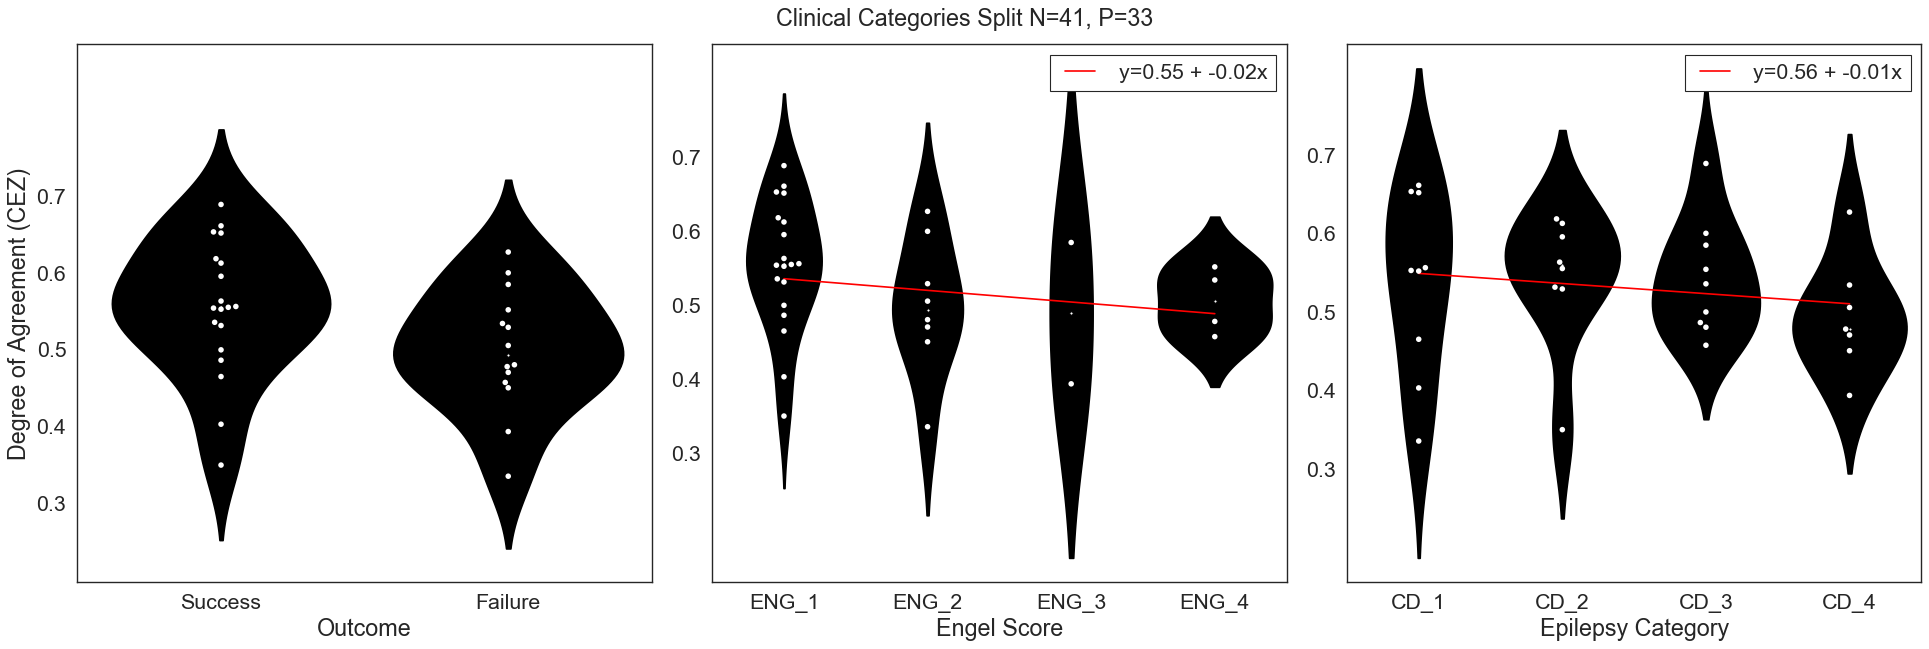

In [59]:
ylabel = "Degree of Agreement (CEZ)"

outcome_dabest = dabest.load(data=outcome_df, x='Outcome', y="ezr", 
                             idx=outcome_df['Outcome'].unique()
                            )
engel_dabest = dabest.load(data=engel_df, x='Engel Score', y="ezr", 
                             idx=engel_df['Engel Score'].unique()
                            )
clindiff_dabest = dabest.load(data=clindiff_df, x='Epilepsy Category', y="ezr", 
                             idx=clindiff_df['Epilepsy Category'].unique()
                            )

# make box plot
plt.style.use("classic")
sns.set(font_scale=1.75)
sns.set_style("white")
cols = 3
rows = 1
ylim = [0.3, 0.7]
ylim = None

fig, axs = plt.subplots(rows, cols, figsize=(24,8), constrained_layout=True)
# ax1 = fig.add_subplot(cols, rows, 1)
axs = axs.flatten()
ax = axs[0]
titlestr = f"Outcome Split N={numdatasets} P={numpats}"
titlestr = ""
plot_boxplot_withdf(ax, outcome_df, df_xlabel='Outcome', df_ylabel='ezr', color='black',
                    ylabel=ylabel, titlestr=titlestr, ylim=ylim, yticks=np.linspace(0.3, 0.7, 5))

ax = axs[1]
titlestr = f"Engel Score Split N={numdatasets} P={numpats}"
titlestr = ""
plot_boxplot_withdf(ax, engel_df, df_xlabel='Engel Score', df_ylabel='ezr', color='black',
                    ylabel="", titlestr=titlestr, ylim=ylim,  yticks=np.linspace(0.3, 0.7, 5))
xticks = ax.get_xticks()
ax.plot(xticks, Y_pred_engel, color='red', label=f"y={engel_intercept:.2f} + {engel_slope:.2f}x")
ax.legend()

ax = axs[2]
titlestr = f"Clin Difficulty Split N={numdatasets} P={numpats}"
titlestr = ""
plot_boxplot_withdf(ax, clindiff_df, df_xlabel='Epilepsy Category', df_ylabel='ezr',color='black', 
                    ylabel="", titlestr=titlestr, ylim=ylim,  yticks=np.linspace(0.3, 0.7, 5))
xticks = ax.get_xticks()
ax.plot(xticks, Y_pred_clindiff, color='red', label=f"y={clindiff_intercept:.2f} + {clindiff_slope:.2f}x")
ax.legend()

# fig.tight_layout()
suptitle = f"Clinical Categories Split N={numdatasets}, P={numpats}"
st = fig.suptitle(suptitle)
figpath = os.path.join(figdir, suptitle+".png")
plt.savefig(figpath, bbox_extra_artists=[st], bbox_inches='tight')

Done


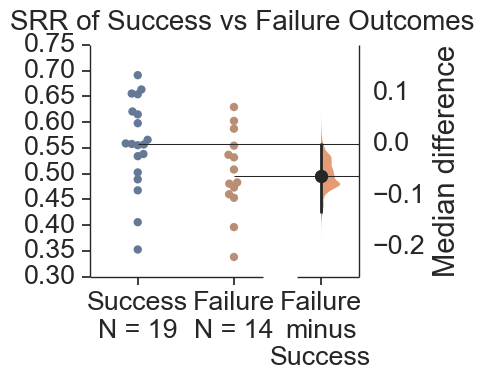

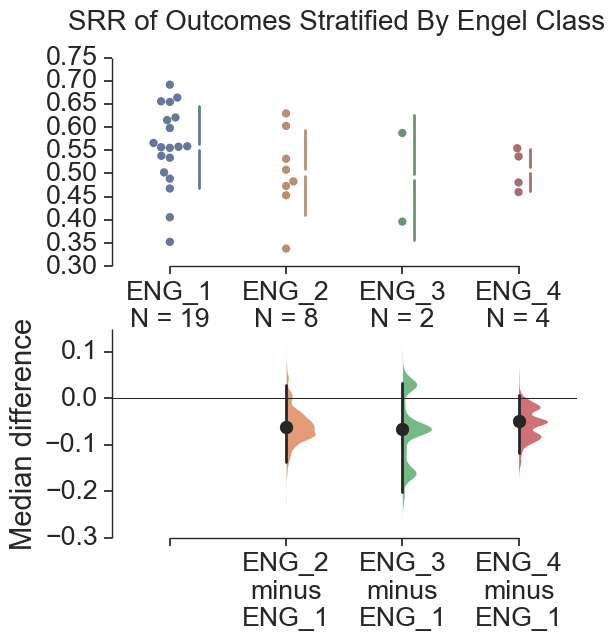

In [83]:
# Produce a Cumming estimation plot.
fig1 = outcome_dabest.median_diff.plot()
ax1_list = fig1.axes
ax1 = ax1_list[0]
fig1.suptitle("SRR of Success vs Failure Outcomes", fontsize=20)
fig1.tight_layout()
# print(fig1, ax1)
# print(ax1.)
fig2 = engel_dabest.median_diff.plot()
ax2_list = fig2.axes
ax2 = ax2_list[0]
fig2.suptitle("SRR of Outcomes Stratified By Engel Class", fontsize=20)
fig2.tight_layout()
print("Done")
# clindiff_dabest.mean_diff.plot()

# Load in Previous Analysis

In [114]:
from eztrack.edv.plot_fragility_heatmap import PlotFragilityHeatmap
from eztrack.edv.baseplot import BasePlotter

In [115]:
plotter = BasePlotter(figdir)

In [107]:
trimmed_dataset_dict = np.load(f"/Users/adam2392/Downloads/improved_allmap_embc_datasets.npy", allow_pickle=True)
trimmed_dataset_ids = np.load(f"/Users/adam2392/Downloads/improved_allmap_embc_datasetids.npy", allow_pickle=True)
trimmed_patient_ids = np.load(f"/Users/adam2392/Downloads/improved_allmap_embc_patientids.npy", allow_pickle=True)
trimmed_chanlabels = np.load(f"/Users/adam2392/Downloads/improved_allmap_embc_chanlabels.npy", allow_pickle=True)
trimmed_cezcontacts = np.load(f"/Users/adam2392/Downloads/improved_allmap_embc_cezcontacts.npy", allow_pickle=True)

In [111]:
print(trimmed_dataset_dict.shape)
print(len(trimmed_patient_ids))
# print(trimmed_cezcontacts[0])

(60,)
60
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']


In [112]:
for i, dataset in enumerate(trimmed_dataset_dict):
    patient_id = trimmed_patient_ids[i]
    dataset_id = trimmed_dataset_ids[i]
    print(dataset.shape)
    
    break

(925, 86, 86)
